In [1]:
# Cell to load dataset, only run once since dataset is very very large
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

print("starting")
df_total = pd.read_csv('Data/Flights.csv')
df_temp1 = df_total[df_total['ORIGIN_AIRPORT'] == 'BOS']
df_temp2 = df_temp1[df_temp1['CANCELLED'] == 0]
df = df_temp2[df_temp2['DIVERTED'] == 0]
print("DONE")
# Our prediction task is estimating delay so we do not care about cancellation. In addition, all data from year
# and origin airport is the same so we remove it
df = df.drop(['CANCELLED', 'DIVERTED', 'CANCELLATION_REASON', 'YEAR', 'ORIGIN_AIRPORT'], axis = 1)
print(df.shape)

starting


/var/folders/6t/hqt0dlv94t756tpd5mb94c4m0000gn/T/ipykernel_51333/1463391467.py:7: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_total = pd.read_csv('Data/Flights.csv')


DONE
(104804, 26)


In [2]:
# Print columns and types
print(df.dtypes)
# print(df.dtypes)

MONTH                    int64
DAY                      int64
DAY_OF_WEEK              int64
AIRLINE                 object
FLIGHT_NUMBER            int64
TAIL_NUMBER             object
DESTINATION_AIRPORT     object
SCHEDULED_DEPARTURE      int64
DEPARTURE_TIME         float64
DEPARTURE_DELAY        float64
TAXI_OUT               float64
WHEELS_OFF             float64
SCHEDULED_TIME         float64
ELAPSED_TIME           float64
AIR_TIME               float64
DISTANCE                 int64
WHEELS_ON              float64
TAXI_IN                float64
SCHEDULED_ARRIVAL        int64
ARRIVAL_TIME           float64
ARRIVAL_DELAY          float64
AIR_SYSTEM_DELAY       float64
SECURITY_DELAY         float64
AIRLINE_DELAY          float64
LATE_AIRCRAFT_DELAY    float64
WEATHER_DELAY          float64
dtype: object


In [3]:
# We also need to remove features we will not have access to ahead of the day of departure
df_outlook = df.drop(['DEPARTURE_TIME', 'TAXI_OUT', 'WHEELS_OFF', 'ELAPSED_TIME', 'AIR_TIME', 'WHEELS_ON', 'TAXI_IN', 'ARRIVAL_TIME',
             'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'TAIL_NUMBER'], axis=1)

In [4]:
# We also need to remove features we will not have access to ahead of the day of departure
df = df.drop(['DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'ELAPSED_TIME', 'AIR_TIME', 'WHEELS_ON', 'TAXI_IN', 'ARRIVAL_TIME',
             'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'TAIL_NUMBER'], axis=1)

In [5]:
# Split in X and y
y = df['ARRIVAL_DELAY']
X = df.drop(['ARRIVAL_DELAY'], axis=1)

In [6]:
# Convert times in hours. Previously they were on 60 minute scale, so preprocessing would not work
X['SCHEDULED_DEPARTURE'] = X['SCHEDULED_DEPARTURE']/60
X['SCHEDULED_ARRIVAL'] = X['SCHEDULED_ARRIVAL']/60

In [7]:

# tscv = TimeSeriesSplit()
# for train_index, test_index in tscv.split(X):
#     print('TRAIN:', train_index, 'TEST:', test_index) 
#     # X_train, X_test = X[train_index], X[test_index]
#     # y_train, y_test = y[train_index], y[test_index]

In [8]:
# ML pipeline cell. Split data using time series split, no test data. 
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline

def MLpipe_TSS_MSE(X, y, preprocessor, ML_algo, param_grid):

    random_states = 1
    n_splits = 5
    refit = True
    final_models = []
    test_scores = []
    for i in range(random_states):
        tscv = TimeSeriesSplit(n_splits=n_splits)
        pipe = make_pipeline(preprocessor, ML_algo)
        grid = GridSearchCV(pipe, param_grid = param_grid, scoring='neg_mean_squared_error', cv=tscv, return_train_score = True,
                            n_jobs = -1, verbose=False, refit=refit).fit(X, y)
        
        print(f'Model: {ML_algo} best params are: {grid.best_params_}')
        print(grid.score(X, y))


In [9]:
from sklearn.metrics import mean_squared_error
# ML Pipeline where one month worth of data is taken out as test data
def MLpipe_TSS_MSE_TEST(X, y, preprocessor, ML_algo, param_grid):
    random_states = 1
    n_splits = 5
    test_scores = []
    splits = [0.5, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90]
    diff = 0.05
    scores = []
    true = []
    pred = []
    
    for i in splits:
        start = int(X.shape[0]*i)
        end = int(X.shape[0]*(i+diff))
        X_other = X[0: start]
        X_test = X[start:end]
        y_other = y[0:start]
        y_test = y[start:end]
        
        tscv = TimeSeriesSplit(n_splits=n_splits)
        pipe = make_pipeline(preprocessor, ML_algo)
        grid = GridSearchCV(pipe, param_grid = param_grid, scoring='neg_mean_squared_error', cv=tscv, return_train_score = True,
                            n_jobs = -1, verbose=False)
        grid.fit(X_other, y_other)
        y_pred = grid.predict(X_test)
        score = mean_squared_error(y_test, y_pred)
        scores.append(score)
        true.append(y_test)
        pred.append(y_pred)
    return scores, true, pred, grid.best_params_

In [10]:
# Cell to encode data use onehot, minmax, and standard
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler


onehot_ftrs = ['AIRLINE', 'DESTINATION_AIRPORT'] # 'DESTINATION_AIRPORT'
minmax_ftrs = ['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'SCHEDULED_TIME', 'MONTH', 'DAY', 'DAY_OF_WEEK'] # 'MONTH', 'DAY', 'DAY_OF_WEEK', 
std_ftrs = ['DISTANCE', 'FLIGHT_NUMBER']#, 'FLIGHT_NUMBER']

# collect all the encoders
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), onehot_ftrs),
        ('minmax', MinMaxScaler(), minmax_ftrs),
        ('std', StandardScaler(), std_ftrs)])

In [15]:
print(X['AIRLINE'].nunique())
print(X['DESTINATION_AIRPORT'].nunique())

11
62


In [8]:
# test your function with a linear regression model (l1 regularization)
from sklearn.linear_model import Lasso
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV

param_grid = {
    'lasso__alpha': np.logspace(-2, 2, 21)  # we use logspace since values can go up to inf
}
print("Linear Regression w/ l1")
# MLpipe_TSS_MSE(X, y, preprocessor, Lasso(), param_grid)
l1_scores, l1_true, l1_pred, l1_params = MLpipe_TSS_MSE_TEST(X, y, preprocessor, Lasso(max_iter=10000), param_grid)
print(l1_scores)

Linear Regression w/ l1
[1466.3037606607081, 1370.956116327128, 1487.7491996673537, 2010.9873547015106, 1200.9935439536494, 1074.0572278993736, 811.0707178311113, 1074.6859924644048, 906.3632827139562]


In [187]:
# For ridge regurlization, I went up to 100 since I saw that alpha can be any value from 0 - inf
from sklearn.linear_model import Ridge
param_grid = {
    'ridge__alpha': np.logspace(-2, 2, 21) # we use logspace since values can go up to inf
}
print("Linear Regression w/ l2")
# MLpipe_TSS_MSE(X, y, preprocessor, Ridge(), param_grid)
l2_scores, l2_true, l2_pred, l2_params = MLpipe_TSS_MSE_TEST(X, y, preprocessor, Ridge(), param_grid)
print(l2_scores)

Linear Regression w/ l2
[1508.1159506985618, 1327.505729318514, 1420.9281730901673, 1993.9270164926422, 1133.5637862651208, 1003.3508786234969, 741.0431359987293, 963.2194288746774, 772.6158265805223]


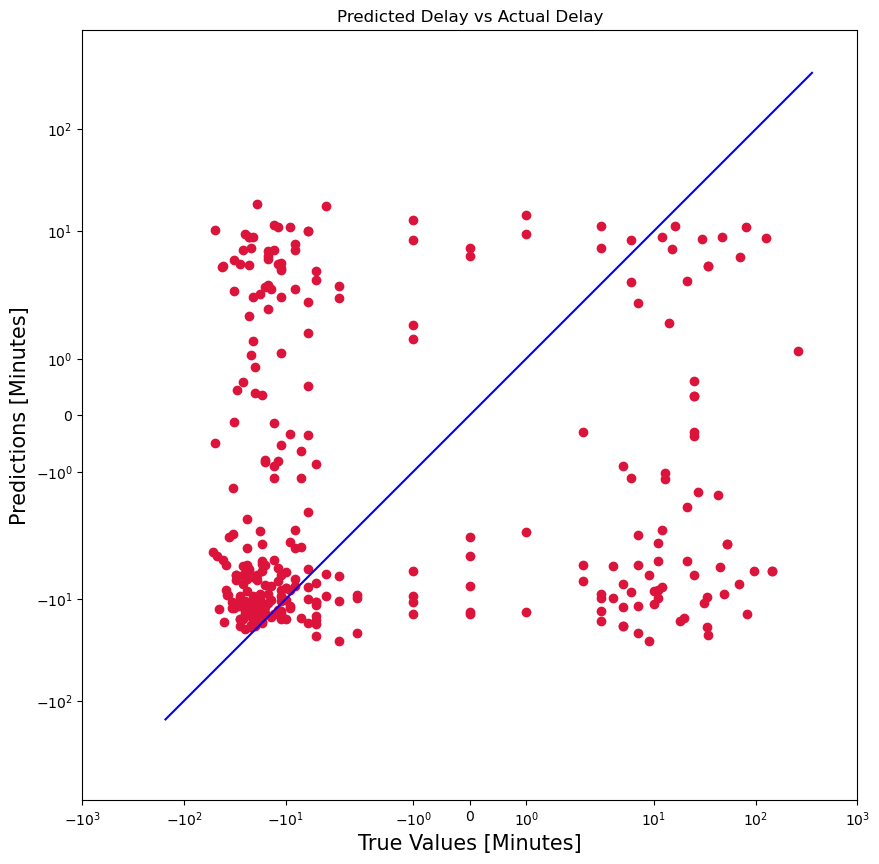

In [324]:
from numpy import random
random.seed(1)
rand = random.randint(0, len(l2_pred[8]),300)
random_seed = 1
predicted_value = []
true_value = []
for i in rand:
    predicted_value.append(l2_pred[8][i])
    true_value.append(list(l2_true[8])[i])
plt.figure(figsize=(10,10))
plt.scatter(true_value, predicted_value, c='crimson')
plt.yscale('symlog')
plt.xscale('symlog')

p1 = max(max(predicted_value), max(true_value)) + 100
p2 = min(min(predicted_value), min(true_value)) - 100
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values [Minutes]', fontsize=15)
plt.ylabel('Predictions [Minutes]', fontsize=15)
plt.axis('equal')
plt.xlim([-1000, 1000])
plt.ylim([-1000, 1000])
plt.title("Predicted Delay vs Actual Delay")
plt.savefig("True_Pred", dpi=300)
plt.show()

In [316]:
from sklearn.linear_model import ElasticNet
param_grid = {
    'elasticnet__alpha': 1/np.logspace(-2, 2, 5),
    'elasticnet__l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
}
print("Linear Regression w/ Elastic Net")
# MLpipe_TSS_MSE(X, y, preprocessor, ElasticNet(max_iter=10000), param_grid)
en_scores, en_true, en_spred, en_params = MLpipe_TSS_MSE_TEST(X, y, preprocessor, ElasticNet(max_iter=5000), param_grid)
print(en_scores)

Linear Regression w/ Elastic Net
[1476.2081253805507, 1359.2767687510066, 1480.128342190481, 2029.0368511345694, 1200.9935439536494, 1074.0572278993736, 811.0707178311113, 1074.6859924644048, 887.1980774092495]


In [11]:
from sklearn.ensemble import RandomForestRegressor
param_grid = {
        'randomforestregressor__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9], # the max_depth should be smaller or equal than the number of features roughly
        'randomforestregressor__max_features': [0.5,0.75,1.0] # linearly spaced between 0.5 and 1
} 
print("RF")
# MLpipe_TSS_MSE(X, y, preprocessor, RandomForestRegressor(), param_grid)
rf_scores, rf_true, rf_pred, rf_params = MLpipe_TSS_MSE_TEST(X, y, preprocessor, RandomForestRegressor(), param_grid)
print(rf_scores)

RF
[1475.366600034477, 1357.2500367750863, 1425.4978818964594, 2004.5191806185703, 1174.8349596994963, 1057.5267586099887, 798.5341457402104, 1003.9093755515221, 838.8145204749436]


In [ ]:
from sklearn.neural_network import MLPRegressor
param_grid = {
    'mlpregressor__hidden_layer_sizes': [[10]],
}
print("MLP")
mlp_scores, mlp_true, mlp_pred, mlp_params = MLpipe_TSS_MSE_TEST(X, y, preprocessor, MLPRegressor(learning_rate_init = 0.001, max_iter = 5000, shuffle=False, batch_size = 512), param_grid)
print(mlp_scores)

MLP


/Users/anoopmanjal/anaconda3/envs/data1030/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/anoopmanjal/anaconda3/envs/data1030/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/anoopmanjal/anaconda3/envs/data1030/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/anoopmanjal/anaconda3/envs/data1030/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the opti

In [164]:
test_scores = []
splits = [0.5, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90]
diff = 0.05
baseline_scores = []
    
for i in splits:
    start = int(X.shape[0]*i)
    end = int(X.shape[0]*(i+diff))
    y_test = y[start:end]
    y_baseline = [np.mean(y_test)] * len(y_test)
    baseline_scores.append(mean_squared_error(y_test, y_baseline))
print(baseline_scores)

[1488.816643807179, 1417.3591356855661, 1486.9588893056932, 2088.4328850300103, 1117.9812013078015, 993.76852383311, 727.0089321353651, 984.0363854087758, 784.5579292800537]


In [188]:
print('RF:', np.mean(rf_scores), np.std(rf_scores))
print('L1:', np.mean(l1_scores), np.std(l1_scores))
print('L2:', np.mean(l2_scores), np.std(l2_scores))
print('EN:', np.mean(en_scores), np.std(en_scores))
print('MLP:', np.mean(mlp_scores), np.std(mlp_scores))
print('Baseline:', np.mean(baseline_scores), np.std(baseline_scores))
print(l2_params)

RF: 1237.3614954889727 355.45042358098425
L1: 1267.0185773576882 344.6858551029958
L2: 1207.1411028824923 377.4640348006282
EN: 1265.8506274460442 351.0435963390138
MLP: 1236.0363017384464 363.7285028467872
Baseline: 1232.1022806437281 406.2367792706289
{'ridge__alpha': 100.0}


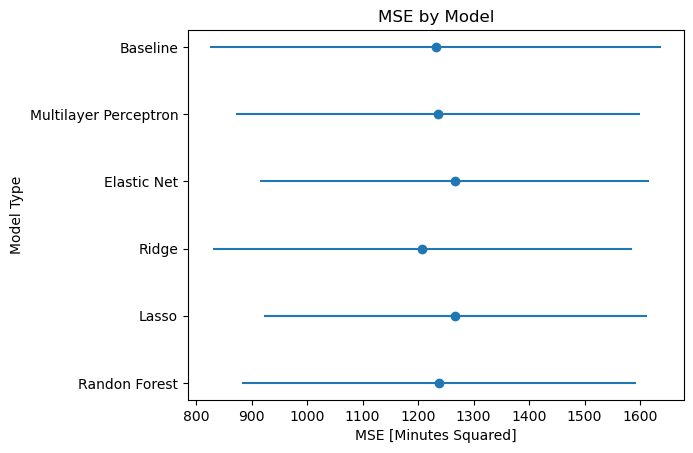

In [189]:
y_plot = ['Randon Forest', 'Lasso', 'Ridge', 'Elastic Net', 'Multilayer Perceptron', 'Baseline']
x_plot = [np.mean(rf_scores), np.mean(l1_scores), np.mean(l2_scores), np.mean(en_scores), np.mean(mlp_scores), np.mean(baseline_scores)]
x_err = [np.std(rf_scores), np.std(l1_scores), np.std(l2_scores), np.std(en_scores), np.std(mlp_scores), np.std(baseline_scores)]
plt.errorbar(x_plot, y_plot, xerr = x_err, fmt='o')
plt.xlabel('MSE [Minutes Squared]')
plt.ylabel('Model Type')
plt.title('MSE by Model')
plt.savefig('RMSE_Mean_Std', dpi=300, bbox_inches="tight")
plt.show()


<ErrorbarContainer object of 3 artists>

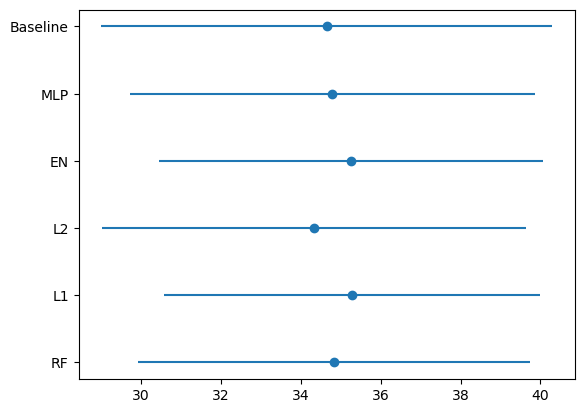

In [83]:
y_labels = ['RF', 'L1', 'L2', 'EN', 'MLP', 'Baseline']

x = [np.mean(np.sqrt(rf_scores)), np.mean(np.sqrt(l1_scores)), np.mean(np.sqrt(l2_scores)), np.mean(np.sqrt(en_scores)), np.mean(np.sqrt(mlp_scores)), np.mean(np.sqrt(baseline_scores))]
x_err = [np.std(np.sqrt(rf_scores)), np.std(np.sqrt(l1_scores)), np.std(np.sqrt(l2_scores)), np.std(np.sqrt(en_scores)), np.std(np.sqrt(mlp_scores)), np.std(np.sqrt(baseline_scores))]
plt.errorbar(x, y_labels, xerr = x_err, fmt='o')

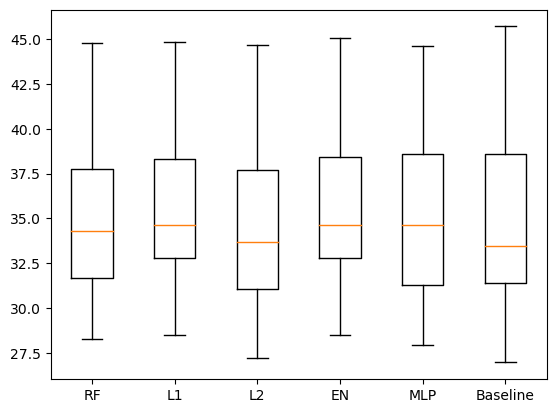

In [84]:
x = ['RF', 'L1', 'L2', 'EN', 'MLP', 'Baseline']
y_labels = [np.sqrt(rf_scores), np.sqrt(l1_scores), np.sqrt(l2_scores), np.sqrt(en_scores), np.sqrt(mlp_scores), np.sqrt(baseline_scores)]
plt.boxplot(y_labels, labels=x)
plt.show()

In [106]:
y_classifier = []
for i in y:
    if (i >= 15):
        y_classifier.append(1)
    else:
        y_classifier.append(0)

In [143]:
from sklearn.metrics import accuracy_score
# ML Pipeline where one month worth of data is taken out as test data
def MLpipe_TSS_Classifier(X, y, preprocessor, ML_algo, param_grid):
    random_states = 1
    n_splits = 5
    test_scores = []
    splits = [0.5, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90]
    diff = 0.05
    scores = []
    true = []
    pred = []
    
    for i in splits:
        start = int(X.shape[0]*i)
        end = int(X.shape[0]*(i+diff))
        X_other = X[0: start]
        X_test = X[start:end]
        y_other = y[0:start]
        y_test = y[start:end]
        
        tscv = TimeSeriesSplit(n_splits=n_splits)
        pipe = make_pipeline(preprocessor, ML_algo)
        grid = GridSearchCV(pipe, param_grid = param_grid, scoring='accuracy', cv=tscv, return_train_score = True,
                            n_jobs = -1, verbose=False)
        grid.fit(X_other, y_other)
        y_pred = grid.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        scores.append(score)
        true.append(y_test)
        pred.append(y_pred)
    return scores, true, pred, grid.best_params_

In [156]:
import xgboost as xgb
param_grid = {
    'xgbclassifier__n_estimators': [550, 600, 650],
    'xgbclassifier__max_depth': [2],
}
print("XGB Classifier")
xgb_scores, xgb_true, xgb_pred, xgb_params = MLpipe_TSS_Classifier(X, y_classifier, preprocessor, xgb.XGBClassifier(), param_grid)
print(xgb_scores)

XGB Classifier
[0.7377862595419847, 0.7568702290076336, 0.7904580152671755, 0.7954198473282442, 0.8112955542835337, 0.874236641221374, 0.8778625954198473, 0.8704198473282443, 0.8732824427480916]


In [157]:
print(xgb_params)

{'xgbclassifier__max_depth': 2, 'xgbclassifier__n_estimators': 550}


In [127]:
# Calculate the baseliene accuracy
from collections import Counter
splits = [0.5, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90]
diff = 0.05
baseline_scores_class = []
    
for i in splits:
    start = int(X.shape[0]*i)
    end = int(X.shape[0]*(i+diff))
    y_true = y_classifier[start:end]
    c = Counter(y_true)
    baseline_scores_class.append(c[0]/len(y_true))


In [158]:
print("XGB Classifier:", np.mean(xgb_scores))
print("Baseline:", np.mean(baseline_scores_class))

XGB Classifier: 0.8208479369051255
Baseline: 0.8332937121174973


In [367]:
# Shap Analysis
start = int(X.shape[0]*0.95)
end = X.shape[0]-1
X_train = X[0:start]
y_train = y[0:start]
X_test = X[start:end]
y_test = y[start:end]

In [368]:
X_prep = preprocessor.fit_transform(X_train)
feature_names = preprocessor.get_feature_names_out()
df_train = pd.DataFrame(data=X_prep.toarray(), columns = feature_names)


# transform the test
X_test = pd.DataFrame(data=X_test,columns = X.columns)
df_test = preprocessor.transform(X_test)
df_test = pd.DataFrame(data=df_test.toarray(), columns = feature_names)
print(f'preprocessed test size: {df_test.shape}')

preprocessed test size: (5240, 81)


In [369]:
final_model = Ridge(alpha=100)
final_model.fit(X_prep, y_train)

Ridge(alpha=100)

In [370]:
import shap
shap.initjs() # required for visualizations later on
# create the explainer object with the random forest model
explainer = shap.LinearExplainer(final_model, df_train)
# transform the test set
# calculate shap values on the first 1000 points in the test
shap_values = explainer.shap_values(df_test)

In [379]:
index = 0
feature_column = df_test.columns[index]
shap.force_plot(explainer.expected_value, shap_values[index,:], features = df_test.iloc[index],feature_names = feature_names)

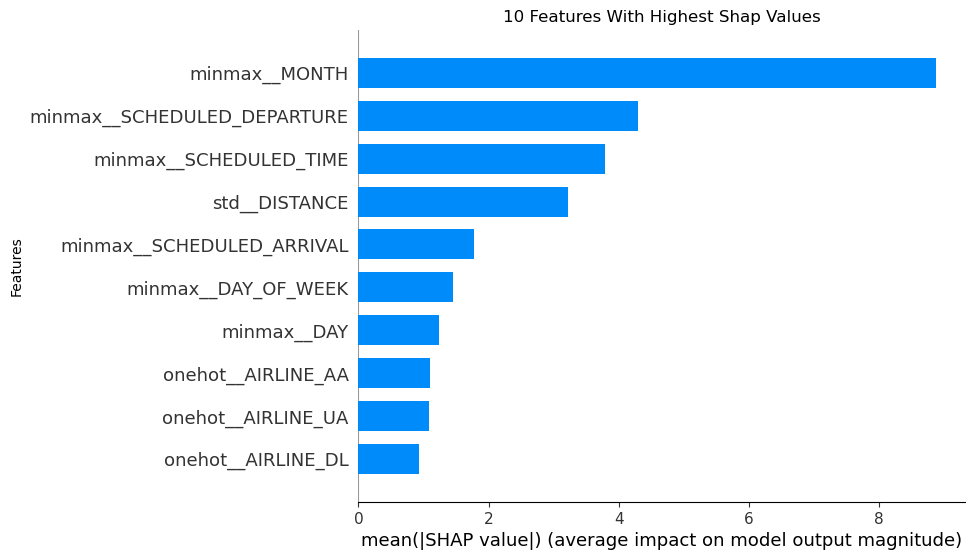

In [371]:
fig = shap.summary_plot(shap_values, df_test, feature_names = feature_names, max_display = 10, plot_type = 'bar', show = False) # change to False if want to save fig
_, h = plt.gcf().get_size_inches()
plt.gcf().set_size_inches(h*2, h)
plt.ylabel('Features')
plt.title('10 Features With Highest Shap Values')
plt.savefig('Shap', dpi=300, bbox_inches="tight")
plt.show()

In [251]:
y_outlook = df_outlook['ARRIVAL_DELAY']
X_outlook = df_outlook.drop(['ARRIVAL_DELAY'], axis=1)
X_outlook['SCHEDULED_DEPARTURE'] = X_outlook['SCHEDULED_DEPARTURE']/60
X_outlook['SCHEDULED_ARRIVAL'] = X_outlook['SCHEDULED_ARRIVAL']/60
# For ridge regurlization, I went up to 100 since I saw that alpha can be any value from 0 - inf
from sklearn.linear_model import Ridge
param_grid = {
    'ridge__alpha': np.logspace(-2, 2, 21) # we use logspace since values can go up to inf
}
print("Linear Regression w/ l2")
# MLpipe_TSS_MSE(X, y, preprocessor, Ridge(), param_grid)
l2_scores_ol, l2_true_ol, l2_pred_ol, l2_params_ol = MLpipe_TSS_MSE_TEST(X_outlook, y_outlook, preprocessor, Ridge(), param_grid)
print(l2_scores_ol)

Linear Regression w/ l2
[239.31049398583767, 179.4782362805807, 191.04242875963112, 190.1278664049822, 180.26713224196888, 170.12667472696506, 170.4145332136447, 184.39123462547226, 204.5083494322109]


In [346]:
# x = ['L2', 'Baseline']
# y_labels = [l2_scores_ol, baseline_scores]
# plt.boxplot(y_labels, labels=x)
# plt.yscale('log')
# #plt.show()

In [359]:
# Shap Analysis
start = int(X.shape[0]*0.95)
end = X.shape[0]-1
X_train_ol = X_outlook[0:start]
y_train_ol = y_outlook[0:start]
X_test_ol = X_outlook[start:end]
y_test_ol = y_outlook[start:end]

In [360]:
X_prep_ol = preprocessor.fit_transform(X_train_ol)
feature_names = preprocessor.get_feature_names_out()
df_train_ol = pd.DataFrame(data=X_prep_ol.toarray(), columns = feature_names)


# transform the test
X_test_ol = pd.DataFrame(data=X_test_ol,columns = X_outlook.columns)
df_test_ol = preprocessor.transform(X_test_ol)
df_test_ol = pd.DataFrame(data=df_test_ol.toarray(), columns = feature_names)
print(f'preprocessed test size: {df_test_ol.shape}')

preprocessed test size: (5240, 82)


In [361]:
final_model_ol = Ridge(alpha=100)
final_model_ol.fit(X_prep_ol, y_train)

Ridge(alpha=100)

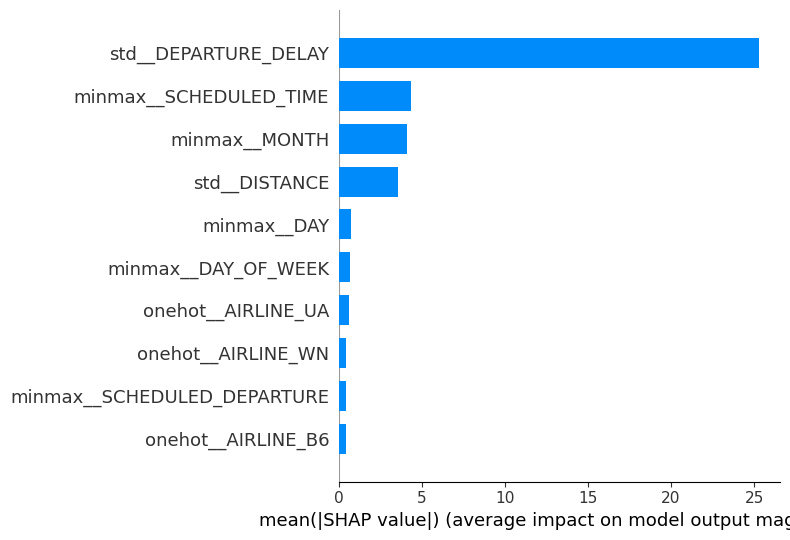

In [363]:
import shap
shap.initjs() # required for visualizations later on
# create the explainer object with the random forest model
explainer_ol = shap.LinearExplainer(final_model_ol, df_train_ol)
# transform the test set
# calculate shap values on the first 1000 points in the test
shap_values_ol = explainer_ol.shap_values(df_test_ol)
shap.summary_plot(shap_values_ol, df_test_ol, feature_names = feature_names, max_display = 10, plot_type = 'bar', show = False) # change to False if want to save fig
# _, h = plt.gcf().get_size_inches()
# plt.gcf().set_size_inches(h*2, h)
# plt.ylabel('Features')
# plt.title('10 Features With Highest Shap Values')
# plt.savefig('Shap', dpi=300, bbox_inches="tight")
# plt.show()